# Denoising Example

## Setup

In [242]:
# Load packages
import MIRT: jim
using Flux
using Random: seed!
using Images, TestImages
using Noise
using Plots
using PyCall
np = pyimport("numpy")
cv = pyimport_conda("cv2", "opencv")
# We will want to suppress some output stuff for neatness
using Suppressor 
# BM3D is not a registered package!
using BM3D

# Load external files
@suppress include("dncnn.jl") # Suppress weight printing

# Create a single Julia function for nlmeans
function nlMeans(img::Array{Gray{T},2}, h::Number = 3) where T
    pyimg = np.uint8(reinterpret(UInt8, noisyImg)) # Convert julia image to np.uint8 array
    img_denoised = cv.fastNlMeansDenoising(pyimg, h=h)
end

# Create a jim interface
function jim(img::Array{Gray{T},2}, title::AbstractString; kwargs...) where T
    tmp = reinterpret(N0f8, img')
    jim(tmp, title; kwargs...)
end

function jim(img::Array{Gray{T},2}; kwargs...) where T
    tmp = reinterpret(N0f8, img')
    jim(tmp; kwargs...)
end;

In [257]:
# using Pkg
# Pkg.add("Flux")
# Pkg.add(url = "https://github.com/Longhao-Chen/BM3D.jl.git")
# Pkg.add("PyCall")
# Pkg.add("Suppressor")
# Pkg.add("TestImages")
# Pkg.add("Noise")
# Pkg.add("JSON")
# Pkg.add("ImageCore")

## Generate the noisy test image

noisyPSNR = 14.7355175f0


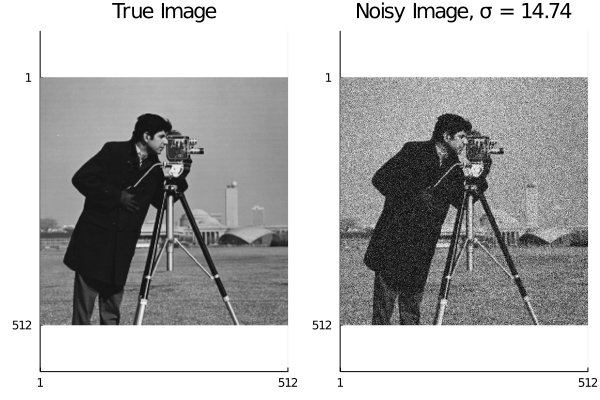

In [250]:
img = testimage("cameraman.tif") # Load the test image
(nx, ny) = size(img) # Determine the size of the test image
σNoise = 0.2 # Noise std. dev.
μNoise = 0.0 # Noise mean
# Using additive gaussian noise
seed!(1)
noisyImg  = add_gauss(img, σNoise, μNoise, clip=true)
noisyPSNR = assess_psnr(noisyImg, img); # PSNR
@show noisyPSNR;
# Do some plotting
pTrue  = jim(     img, "True Image")
pNoisy = jim(noisyImg, "Noisy Image, σ = $(round(noisyPSNR, digits = 2))")
plot(pTrue, pNoisy, colorbar = false)

In [251]:
savefig("rawPlusNoise.pdf")

## Do some denoising

In [252]:
# Using the DNCNN
cnnIm   = dncnn_denoise(noisyImg)
cnnIm   = convert(Array{Gray{N0f8}, 2}, cnnIm)
cnnPSNR = assess_psnr(cnnIm, img);
@show cnnPSNR;

cnnPSNR = 21.245972f0


In [253]:
# Using BM3D
bm3dIm   = @suppress bm3d(noisyImg, σNoise)
bm3dIm   = convert(Array{Gray{N0f8}, 2}, bm3dIm)
bm3dPSNR = assess_psnr(bm3dIm, img);
@show bm3dPSNR;

bm3dPSNR = 27.038666f0


In [254]:
# Using NLMeans via Python
nlMeansIm   = nlMeans(noisyImg, σNoise*255.0)
nlMeansIm   = convert(Array{Gray{N0f8}, 2}, nlMeansIm./255.0)
nlMeansPSNR = assess_psnr(nlMeansIm, img);
@show nlMeansPSNR;

nlMeansPSNR = 25.157568f0


In [255]:
pCNN  = jim( cnnIm, "DNCNN, σ = $(round(cnnPSNR, digits = 2))")
pBM3D = jim(bm3dIm, "BM3D, σ = $(round(bm3dPSNR, digits = 2))")
pNlMeans = jim(nlMeansIm, "NLMeans, σ = $(round(nlMeansPSNR, digits = 2))")
plot(pNoisy, pCNN, pBM3D, pNlMeans, layout = (2,2), colorbar = false)

In [256]:
savefig("denoisingGrid.pdf")